# Reto 1

## Ingeniería de características

#### Miguel Ortiz y Andrea Castiella

In [24]:
import numpy  as np
import pandas as pd
import OurUtils as our
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

In [25]:
FullSet_3 = pd.read_csv('../Reto1-Dataset/1000_tres.csv', header=None)
FullSet_7 = pd.read_csv('../Reto1-Dataset/1000_siete.csv', header=None)

# Reescalado a [0, 1]

FullSet_3 = FullSet_3 / 255.0
FullSet_7 = FullSet_7 / 255.0

## Función extracción de características

In [26]:
def feat_extraction(data, perc=0.5):
    num_feat = 6
    features = np.zeros([data.shape[0], num_feat])
    data = data.values.reshape([data.shape[0],28,28]) # Cada fila es una imagen, reshape a 28x28

    for i in range(data.shape[0]): # Por cada imagen
        img = data[i,:,:]
        # Característica 1
        feat_1  = np.sum(img[:, :int(img.shape[1]*(perc))]) # Suma de los pixels del % izquierdo de la imagen
        features[i, 0] = feat_1
        # Característica 2
        feat_2 = np.sum(img[int(img.shape[0]*(1-perc)):, :]) # Suma de los pixels del % mitad inferior de la imagen
        features[i, 1] = feat_2
        # Característica 3
        feat_3 = np.sum(img[:, int(img.shape[1]*(1-perc)):]) # Suma de los pixels del % mitad derecho de la imagen
        features[i, 2] = feat_3
        # Característica 4
        feat_4 = np.sum(img[:int(img.shape[0]*(perc)), :]) # Suma de los pixels del % mitad superior de la imagen
        features[i, 3] = feat_4
        # Característica 5
        feat_5 = np.sum(img[int(img.shape[0]*(1-perc)):,int(img.shape[1]*(perc)):]) # Suma del cuadrante inferior derecho
        features[i, 4] = feat_5
        # Característica 6
        feat_6 = np.amax(np.sum(img, axis=0)) # Máximo valor de la suma de las columnas
        features[i, 5] = feat_6
    col_names = ['feat_1','feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']
    return pd.DataFrame(features,columns = col_names)


## Features

In [27]:
FullSet = our.join_features_labels(FullSet_3, FullSet_7)
seed = 1234
theta = 0.5
X_full = feat_extraction( FullSet.drop('label', axis=1))
Y_full = FullSet[['label']]
test_size = 0.2
splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
split_ix = splitter.split(X_full,Y_full)

for train_ix, test_ix in split_ix:
    X_train = X_full.loc[train_ix].reset_index(drop=True)
    #Reordena los índices
        #print(X_full.loc[train_ix])
        #print(X_train)
    Y_train = Y_full.loc[train_ix].reset_index(drop=True)
    X_test  = X_full.loc[test_ix].reset_index(drop=True)
    Y_test  = Y_full.loc[test_ix].reset_index(drop=True)

In [28]:
feats = ['feat_5','feat_4']
scaler = MinMaxScaler()
X = scaler.fit_transform(X_train[feats])
Y = Y_train.values.ravel() #Devuelve data como numpy

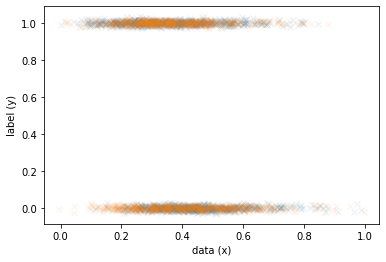

In [29]:
plt.plot(our.jitter(X,sigma=0.01), our.jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Logistic Regression

[0.55241938 0.39147819 0.45953829 ... 0.26766353 0.50765218 0.20828533]


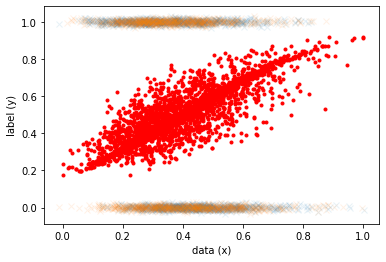

In [30]:
from sklearn.linear_model import LogisticRegression

recta_regresion = LogisticRegression()
recta_regresion.fit(X,Y)
y_CDF = recta_regresion.predict_proba(X)
y_pred = y_CDF[:,0]  #<-- use 0 instead of 1 to see the logistic curve of the other class
print(y_pred)

plt.plot(our.jitter(X,sigma=0.01), our.jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.plot(X, y_pred, '.r')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix
X_test = scaler.transform(X_test[feats])
y_test_pred = recta_regresion.predict(X_test)
conf_mat = confusion_matrix(Y_test, y_test_pred)
hits = conf_mat[0,0]+conf_mat[1,1]
fails = conf_mat[0,1]+conf_mat[1,0]
strlog = "Fold : HITS = %d, FAILS = %d" %(hits , fails )
print(strlog)

Fold : HITS = 262, FAILS = 138


In [ ]:
## Discriminant Function

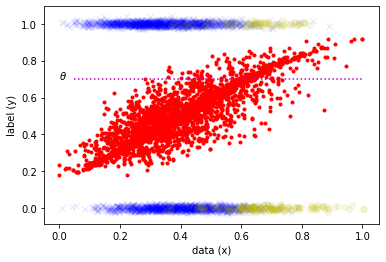

In [32]:
theta = 0.7 # Parámetro que define la función de discriminación.

ix_1 = y_pred < theta
ix_0 = ~ix_1
plt.plot( our.jitter(X[ix_1],sigma=0.01), \
          our.jitter(Y[ix_1],sigma=0.01), \
          'bx',alpha=0.1)
plt.plot( our.jitter(X[ix_0],sigma=0.01), \
          our.jitter(Y[ix_0],sigma=0.01), \
          'yo',alpha=0.1)
plt.text(0,theta, r'$ \theta $')
plt.plot(X,y_pred,'.r')
plt.plot([0.05,1],[theta,theta],'m:')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Competition data

In [33]:
# Using the transform method we can use the same mean and variance as it is calculated
# from our training data to transform our test data (using fit_transform). Thus, the
# parameters learned by our model using the training data will help us to transform our test data.

# load competition data
challenge_data = pd.read_csv('../Reto1-Dataset/reto1_X.csv', header=None)
challenge_data = challenge_data/255.0
challenge_features = feat_extraction(challenge_data)
challenge_features = scaler.transform(challenge_features[feats])
y_challenge = recta_regresion.predict_proba(challenge_features)
y_challenge_pred = y_challenge[:,1]
ix_3_chall = y_challenge_pred < theta
ix_7_chall = ~ix_3_chall
print(y_challenge)
print(ix_7_chall)

[[0.25154407 0.74845593]
 [0.39227069 0.60772931]
 [0.35526393 0.64473607]
 ...
 [0.50000593 0.49999407]
 [0.6718061  0.3281939 ]
 [0.34836192 0.65163808]]
[ True False False ... False False False]


In [34]:
np.savetxt('reto1_Ypred.csv', ix_7_chall, fmt='%i', delimiter=',')